## Lab 9: Predicting Forest Cover Type with SVMs

Author: Eva Newby

Collaborators: Emma Bea Mitchell

### Introduction
In this lab, we will explore the application of Support Vector Machines (SVMs) and Random Forests (RFs) for multi-class classification using cartographic variables. Specifically, we will predict forest cover type based on a variety of environmental features such as elevation, soil type, and land aspect.

Understanding forest cover classification is crucial for natural resource management. Land managers and conservationists rely on accurate predictions of vegetation types to make informed decisions about wildlife habitats, fire management, and sustainable forestry practices. However, direct field assessments of forest cover can be costly and time-consuming, making predictive models a valuable tool for estimating cover types in large or inaccessible regions.

Dataset info here: https://archive.ics.uci.edu/dataset/31/covertype


### Step 0: Load Libraries and Data

In [19]:
import pandas as pd
import time
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

# Load the dataset
df = pd.read_csv("/courses/EDS232/Data/covtype_sample.csv")

### Step 1: Data Preprocessing 

Before building our classification models, we need to prepare the dataset by separating the features target variable (`Cover_Type`) and  splitting the data into training and test sets. 

We didn't explicitly discuss it in lecture, but SVMs are sensitive to feature scale.  Use `describe()` to summarize the dataset.  Do you see anything that would require scaling of the data?  If so, apply that transformation.

In [2]:
# Summarize data
print(df.describe())

          Elevation        Aspect         Slope  \
count  10000.000000  10000.000000  10000.000000   
mean    2955.599500    154.450000     14.114700   
std      281.786673    111.851861      7.499705   
min     1860.000000      0.000000      0.000000   
25%     2804.750000     58.000000      9.000000   
50%     2995.000000    126.000000     13.000000   
75%     3159.000000    258.000000     18.000000   
max     3846.000000    359.000000     65.000000   

       Horizontal_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
count                      10000.000000                     10000.000000   
mean                         268.097600                        45.755300   
std                          211.899673                        58.034207   
min                            0.000000                      -164.000000   
25%                           95.000000                         7.000000   
50%                          218.000000                        29.000000   
75%     

Do you see anything that would require scaling of the data?  If so, apply that transformation.

Yes, some of the features (like distances versus soil type) have different scales. 

In [3]:
# Define features (x) and targets (y)
X = df.drop("Cover_Type", axis = 1)
y = df["Cover_Type"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Step 2: Hyperparameter Tuning for SVM
To optimize our SVM model, we need to search for the best hyperparameters that maximize classification accuracy. Since SVM performance depends heavily on `C`, `kernel`, and `gamma`, we will use `GridSearchCV()` to systematically test different combinations. Initialize a cross validation object with 5 folds using `StratifiedKFold`. Check out how `StratifiedKFold` differs from `Kfold` [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html). 

Then, set up a grid to test different values of: 
- `C` (regularization strength): how strictly the model fits the training data
  - Candidate parameter values: `(0.1, 1, 10, 100)`
- `kernel` (decision boundary shape): compares linear and radial basis function shapes
  - Candidate parameter values: (linear, rbf)
- `gamma` (influence of training observations): influence of individual points on decision boundary
  - Candidate parameter values: (scale, auto)

As models and datasets become more complex, consideration of computation time becomes more important.  You'll use `time.time()` to measure the time required to fit the grid object.  

**Print the best parameters from your model, as well as the time required to fit the grid object.** 

In [4]:
# Initialize SVM model
svm_model = SVC()

# Set up parameters
params = {'C': [0.1, 1, 10, 100],
          'kernel': ['linear', 'rbf'], 
          'gamma': ['scale', 'auto']}

# Define cv
cv = StratifiedKFold(n_splits = 5,
                    shuffle = True,
                    random_state = 42)

# test different combos
grid_search  = GridSearchCV(estimator = svm_model, 
                           param_grid = params,
                           cv = cv,
                           n_jobs = -1)

# Measure time requireds to fit grid object
start_time = time.time()

# fit grid search
grid_search.fit(X_train_scaled, y_train)

# measure end time
end_time = time.time()
total_time = end_time - start_time

# Print best parameters and times
print(f"Best parameters: {grid_search.best_params_}")
print(f"Time taken to fit the grid: {total_time:.2f} seconds")

Best parameters: {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
Time taken to fit the grid: 560.68 seconds


### Step 3: Build and fit a Random Forest for comparison

Let's compare our SVM to a Random Forest classifier.  Create a grid for cross-validation with three hyperparameters of your choice to tune, along with three sensible values for each one.  
**Print the best parameters from your model, as well as the time required to fit the grid object.** 

In [5]:
# Initialize random forest model NEED TO GO OVER THIS WHOLE SECTION WITH ANNIE -----------
random_forest_model = RandomForestClassifier(random_state = 42)

# set up parameters
params_random_forest = {'n_estimators':[10, 50, 100],
                        'max_depth': [5, 12, 50],
                       'bootstrap' : [True, False]}

# set up cross validation
cv = StratifiedKFold(n_splits = 5,
                    shuffle = True,
                    random_state = 42)

# set up grid search
grid_search_rf = GridSearchCV(estimator=random_forest_model, 
                              param_grid=params_random_forest,
                              cv=cv,
                              n_jobs=-1)

# Measure time requireds to fit grid object
start_time_rf = time.time()

# fit grid search
grid_search_rf.fit(X_train_scaled, y_train)

# measure end time
end_time_rf = time.time()
total_time_rf = end_time_rf - start_time_rf

# Print best parameters and times
print(f"Best parameters: {grid_search_rf.best_params_}")
print(f"Time taken to fit the grid: {total_time_rf:.2f} seconds")

Best parameters: {'bootstrap': False, 'max_depth': 50, 'n_estimators': 100}
Time taken to fit the grid: 5.56 seconds


### Step 4: Model Predictions and Evaluation
Now that you have trained and optimized both a SVM and RF model, you will evaluate their performances on the test set to prepare for model comparison. In this step, you will:
- Use the best models from `GridSearchCV()` to make predictions on the test set
- Generate a confusion matrix for each model to visualize classification performance


In [6]:
# Get best models
best_svm = grid_search.best_estimator_
best_rf = grid_search_rf.best_estimator_

# make SVM Predictions
svm_preds = best_svm.predict(X_test_scaled)

# make RF Predictions
rf_preds = best_rf.predict(X_test_scaled)

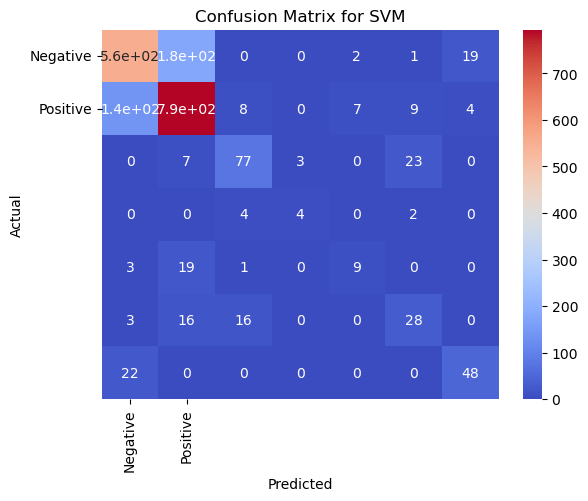

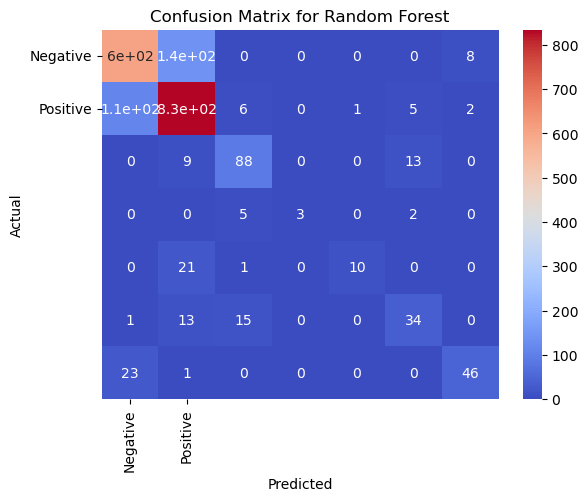

In [15]:
# Make confusion matrix for SVM
def plot_confusion_matrix(y_true, y_pred, svm_model):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, cmap="coolwarm", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix for {svm_model}")
    plt.show()
    
# Make confusion matrix for random forest
def plot_confusion_matrix(y_true, y_pred, random_forest_model):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, cmap="coolwarm", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix for {random_forest_model}")
    plt.show()

# Plot Confusion Matrices
plot_confusion_matrix(y_test, svm_preds, "SVM")
plot_confusion_matrix(y_test, rf_preds, "Random Forest")

In [20]:
# Print results of classification_report
print("SVM Model Performance:")
print(classification_report(y_test, svm_preds))

print("\nRandom Forest Model Performance:")
print(classification_report(y_test, rf_preds))

SVM Model Performance:
              precision    recall  f1-score   support

           1       0.77      0.74      0.75       754
           2       0.78      0.83      0.80       961
           3       0.73      0.70      0.71       110
           4       0.57      0.40      0.47        10
           5       0.50      0.28      0.36        32
           6       0.44      0.44      0.44        63
           7       0.68      0.69      0.68        70

    accuracy                           0.76      2000
   macro avg       0.64      0.58      0.60      2000
weighted avg       0.75      0.76      0.76      2000


Random Forest Model Performance:
              precision    recall  f1-score   support

           1       0.82      0.80      0.81       754
           2       0.82      0.87      0.84       961
           3       0.77      0.80      0.78       110
           4       1.00      0.30      0.46        10
           5       0.91      0.31      0.47        32
           6       0.

### Step 5: Gather and display additional performance metrics
Now display the accuracy score and training time required for each model to so we can compare the models.

In [18]:
# Calculate Accuracy Scores
svm_accuracy = accuracy_score(y_test, svm_preds)
rf_accuracy = accuracy_score(y_test, rf_preds)

# Print Accuracy Scores
print(f"SVM Accuracy: {svm_accuracy:.2f}")
print(f"Random Forest Accuracy: {rf_accuracy:.2f}")

# Display Training Times (recorded earlier)
svm_training_time = end_time - start_time
rf_training_time = end_time_rf - start_time_rf

print(f"SVM Training Time: {svm_training_time:.2f} seconds")
print(f"Random Forest Training Time: {rf_training_time:.2f} seconds")

SVM Accuracy: 0.76
Random Forest Accuracy: 0.81
SVM Training Time: 560.68 seconds
Random Forest Training Time: 5.56 seconds


### Step 6: Compare the models
Now that we have trained, optimized, and evaluated both SVM and RF models, we will compare them based on overall accuracy, training time, and types of errors made.

Based on these comparisons, which model is more suitable for this task?  


Based on the numbers above, the random forest model outperforms the SVM model in accuracy and training time. 